In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from kp.utils.constants import EXPERIMENTS_DIR
from kp.plotting.plotting import find_results_files, organize_results, plot_metric

In [19]:
base_experiments_dir = EXPERIMENTS_DIR

In [20]:
layers_setting = "all_layers"
base_experiments_dir = base_experiments_dir / layers_setting
base_experiments_dir

PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/all_layers')

In [21]:
allow_smoke_test = False
all_my_results_files = find_results_files(base_experiments_dir, allow_smoke_test)

Found 187 'results.json' files.


In [22]:
all_my_results_files

[PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/r/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-13_10-05-19/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/no_patching/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-13_10-05-19/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/not_lt/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-13_10-05-19/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/r_lt/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-13_10-05-19/sentence_

In [23]:
organized_results = organize_results(all_my_results_files, base_experiments_dir)

Attempted to parse 187 files.
Successfully parsed 187 paths and calculated metrics for 187.
Organized data into 1 datasets.


In [24]:
organized_results

defaultdict(<function kp.plotting.plotting.organize_results.<locals>.<lambda>()>,
            {'fake_movies_real_actors': defaultdict(<function kp.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'lm_head_never': defaultdict(<function kp.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'gpt2-xl': defaultdict(dict,
                                                   {'sentence_1': {'r': {'mean_target_rank': 603.4544544544544,
                                                      'top_k_accuracy': 0.007007007007007007,
                                                      'mean_target_prob': 0.0014022634900567464},
                                                     'no_patching_sft2pre': {'mean_target_rank': 584.1201201201201,
                                                      'top_k_accuracy': 0.012012012012012012,
                                   

In [25]:
filtered_data = {
    dataset: {
        "lm_head_never": models["lm_head_never"]
    }
    for dataset, models in organized_results.items()
    if "lm_head_never" in models
}
# filtered_data = organized_results

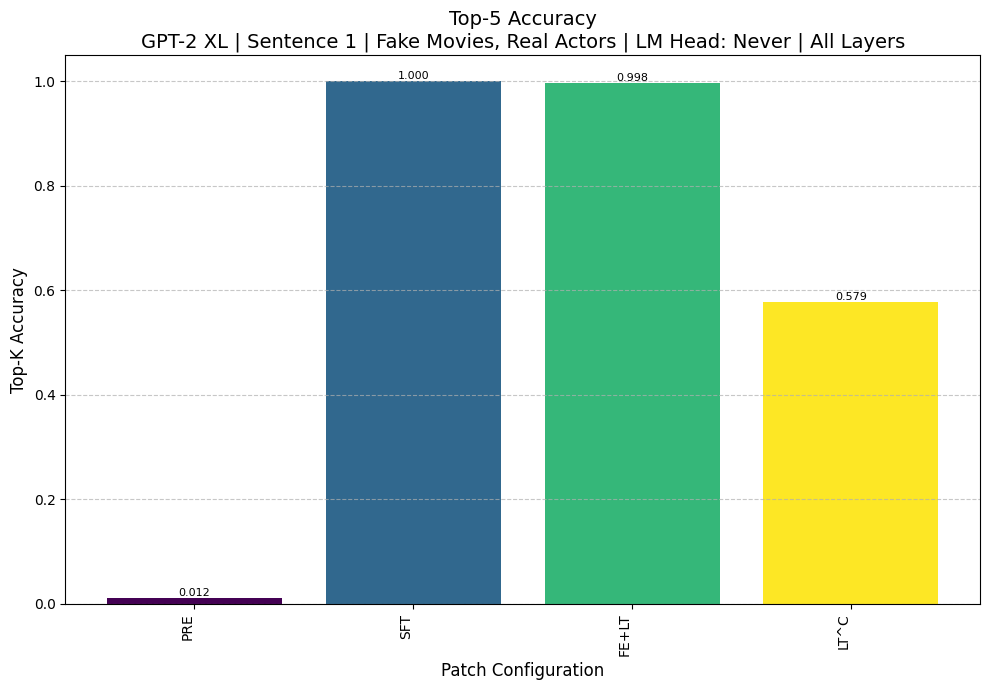

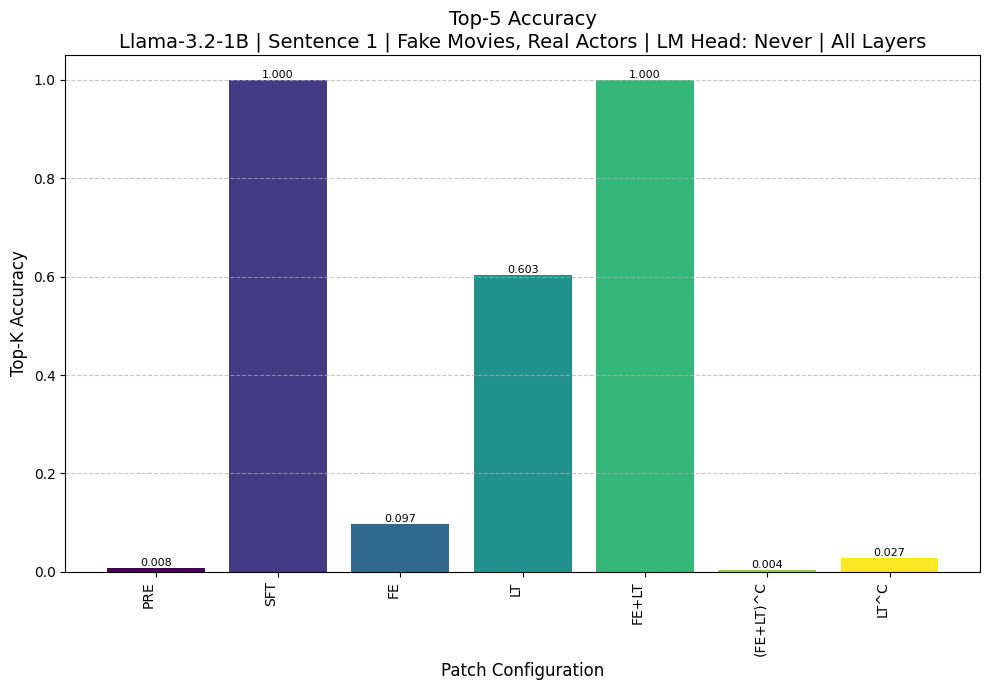

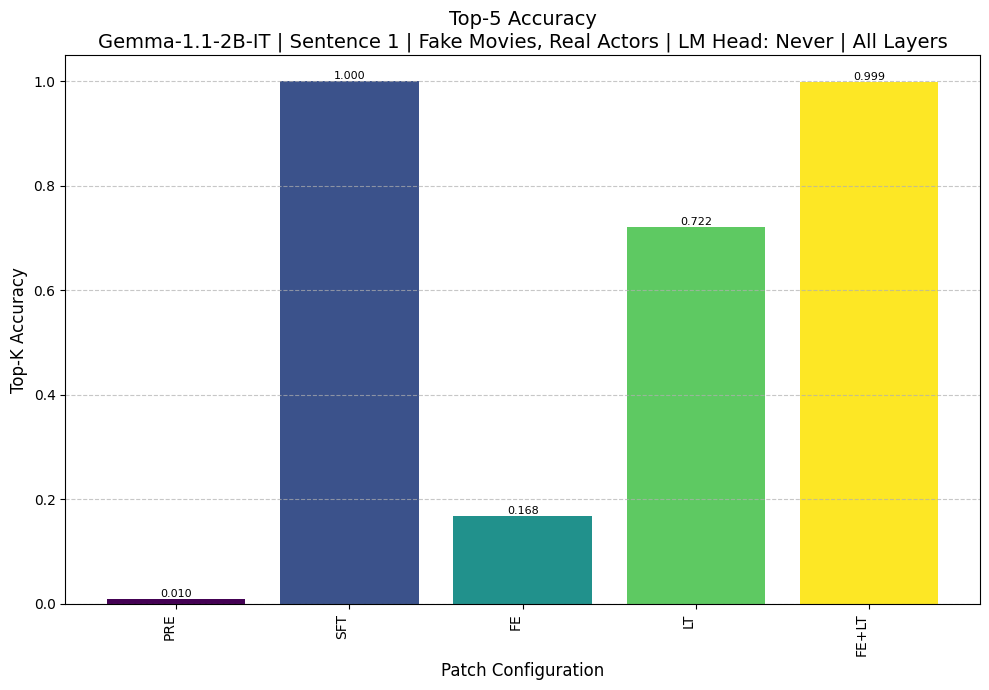

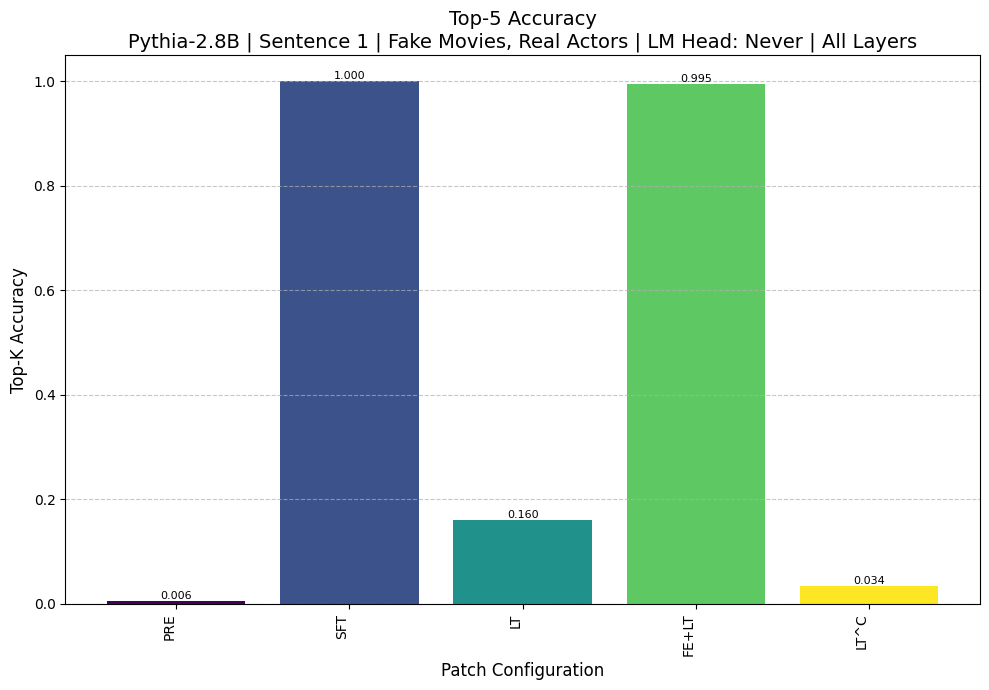

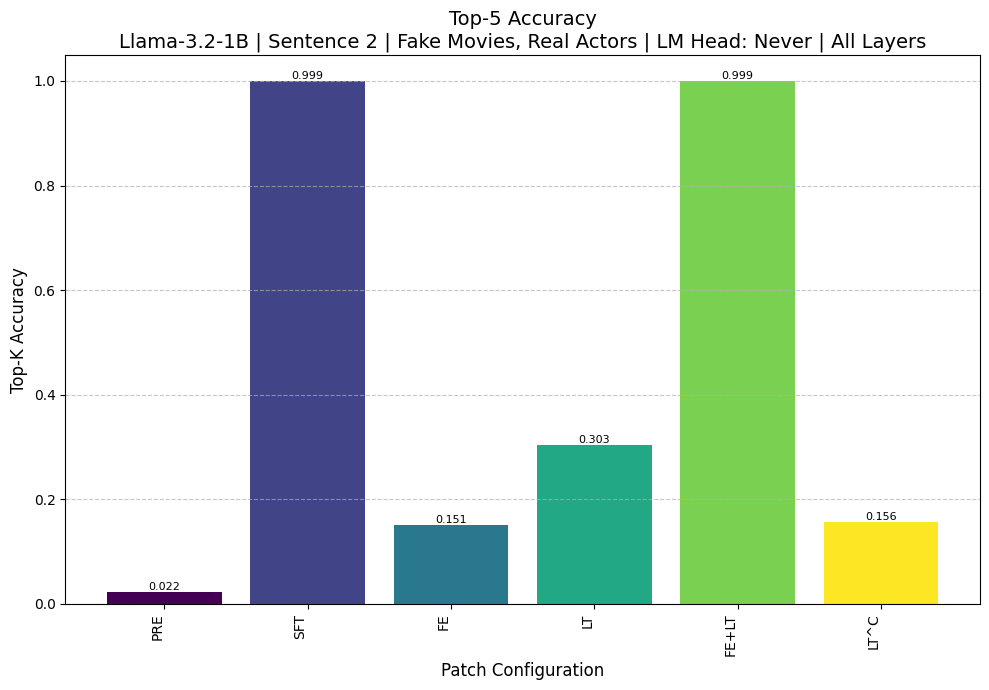

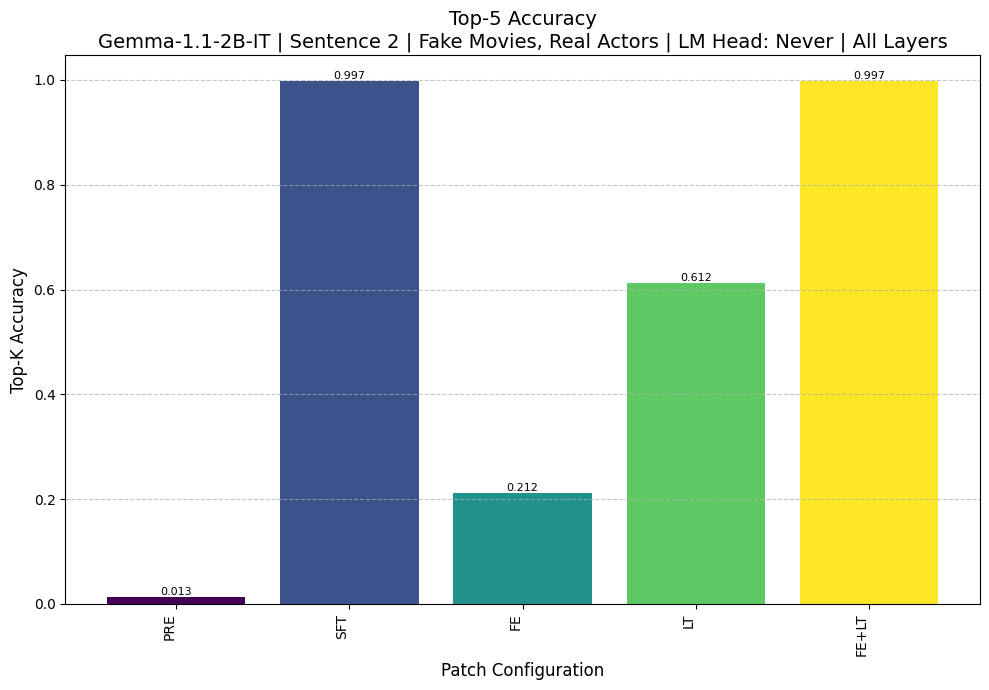

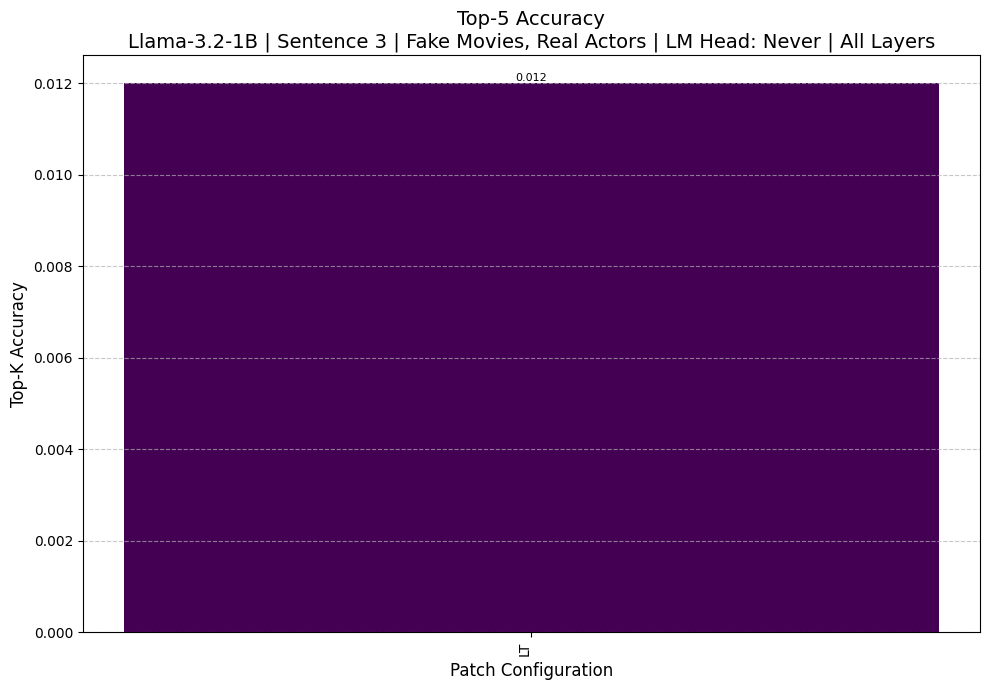

No valid data for top_k_accuracy in fake_movies_real_actors / sentence_3 / gemma
No valid data for top_k_accuracy in fake_movies_real_actors / sentence_3 / pythia-2.8b


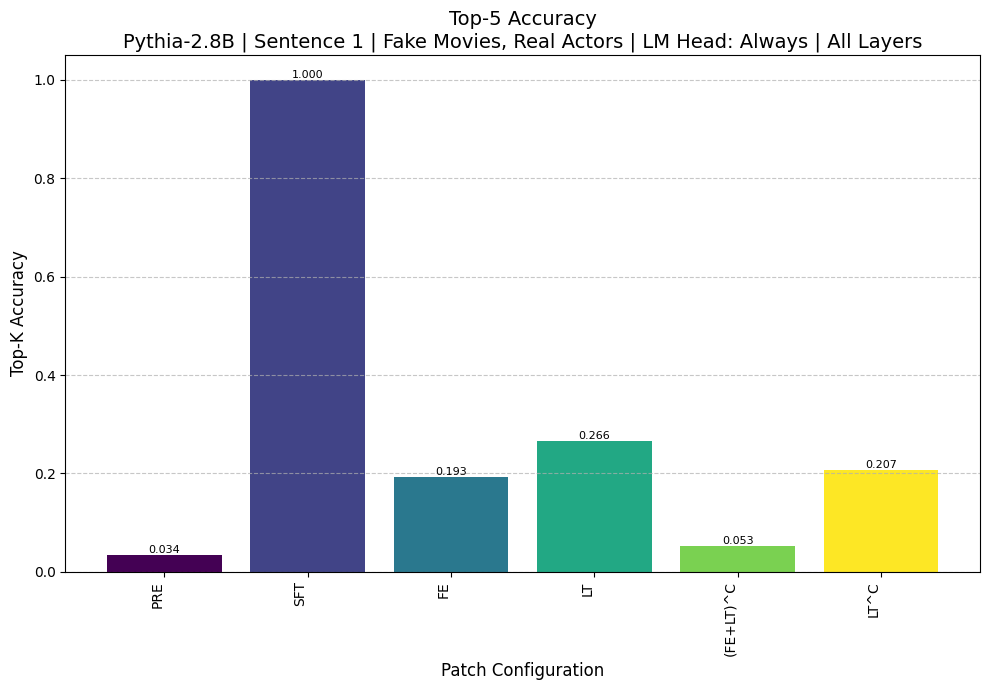

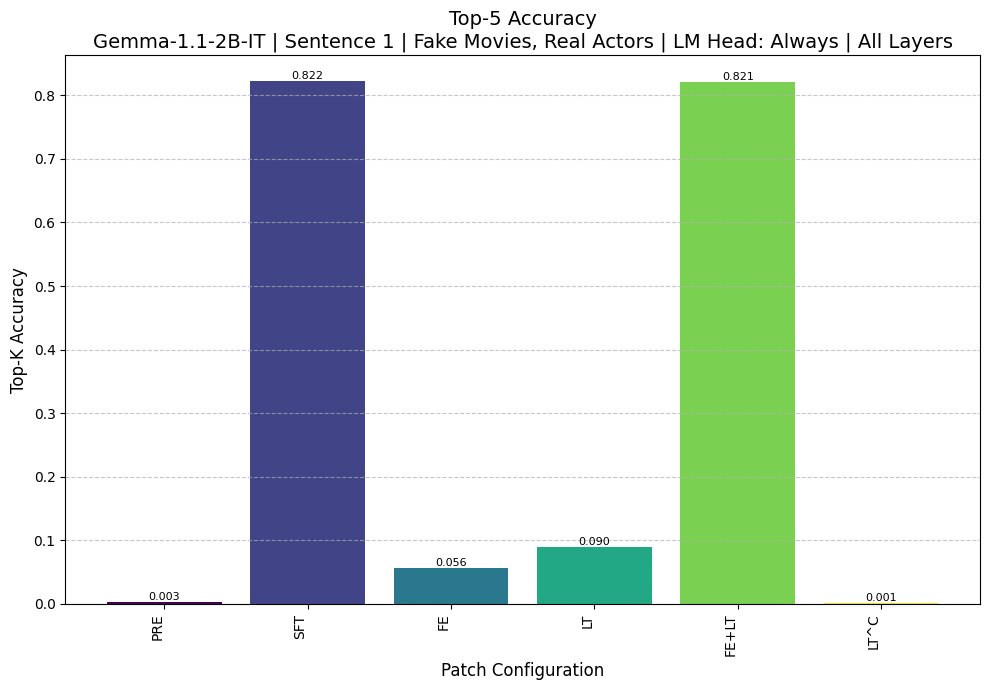

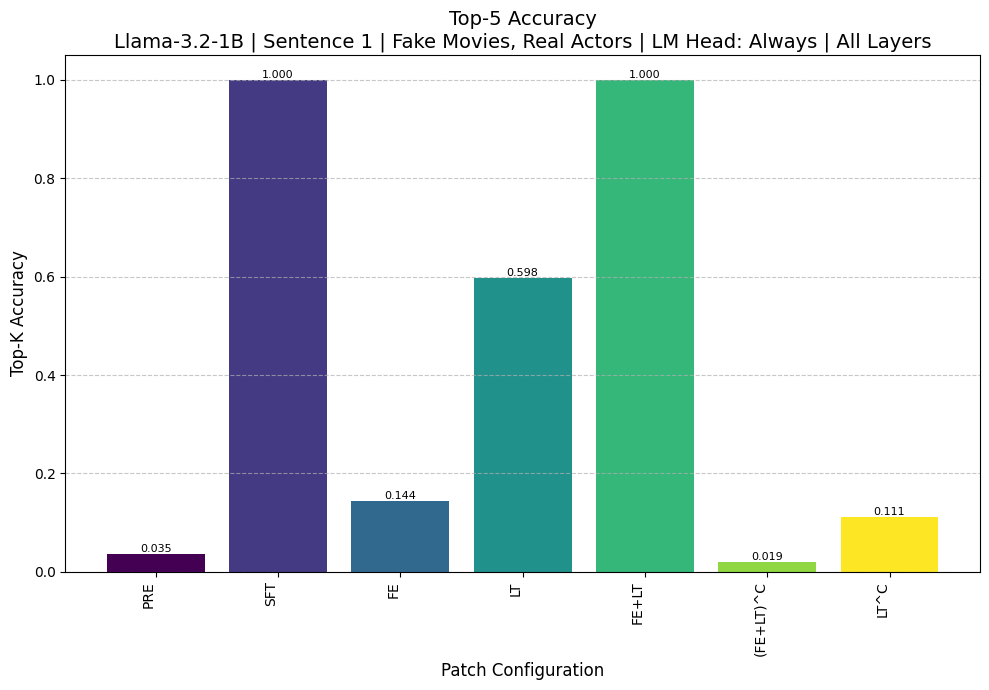

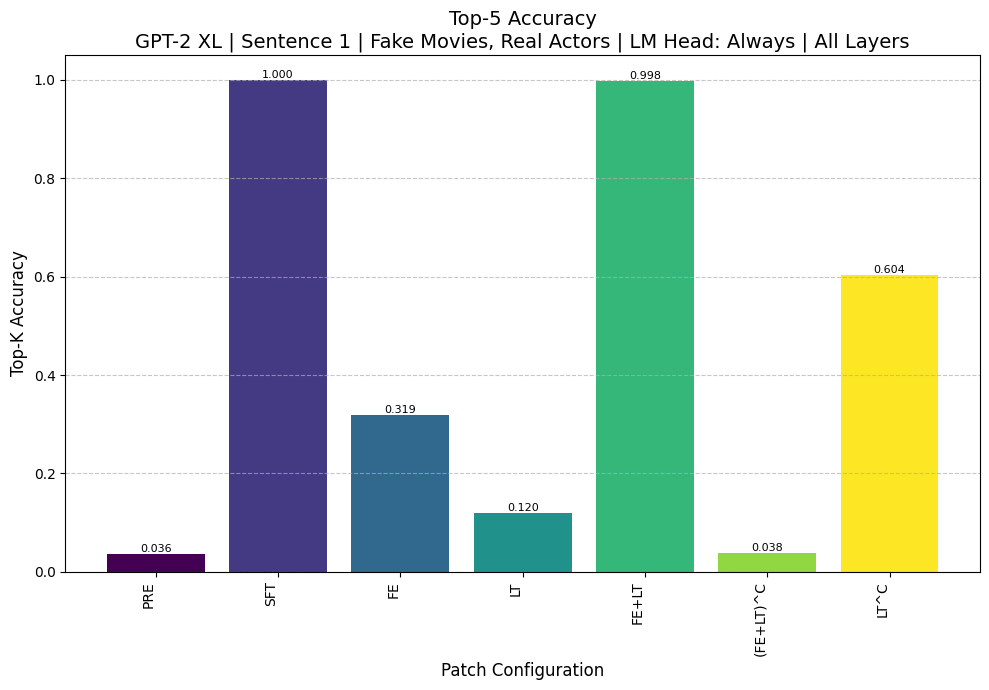

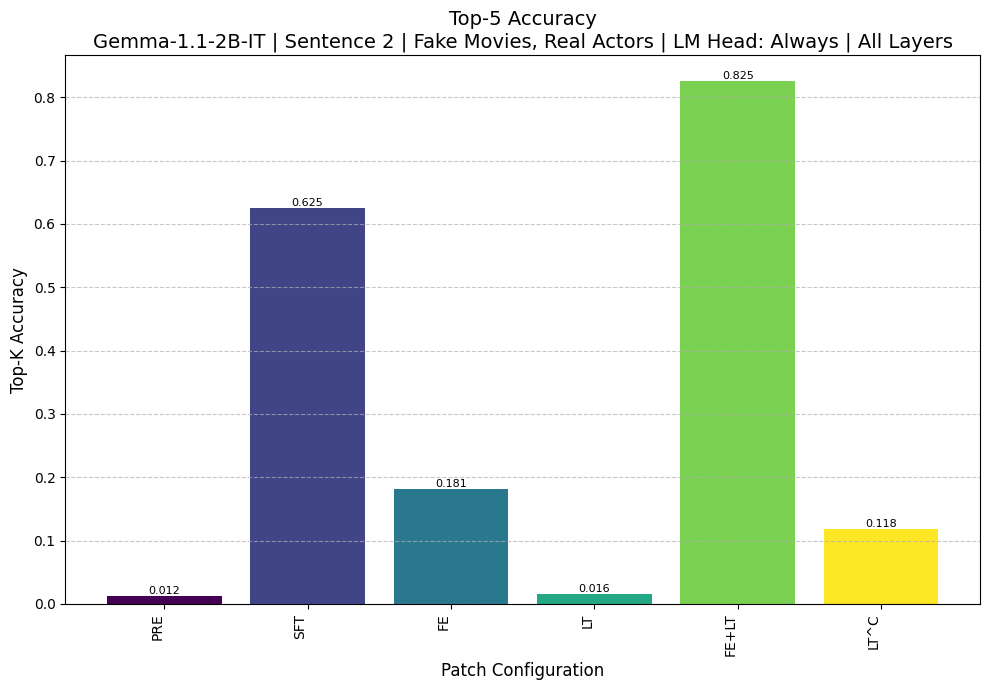

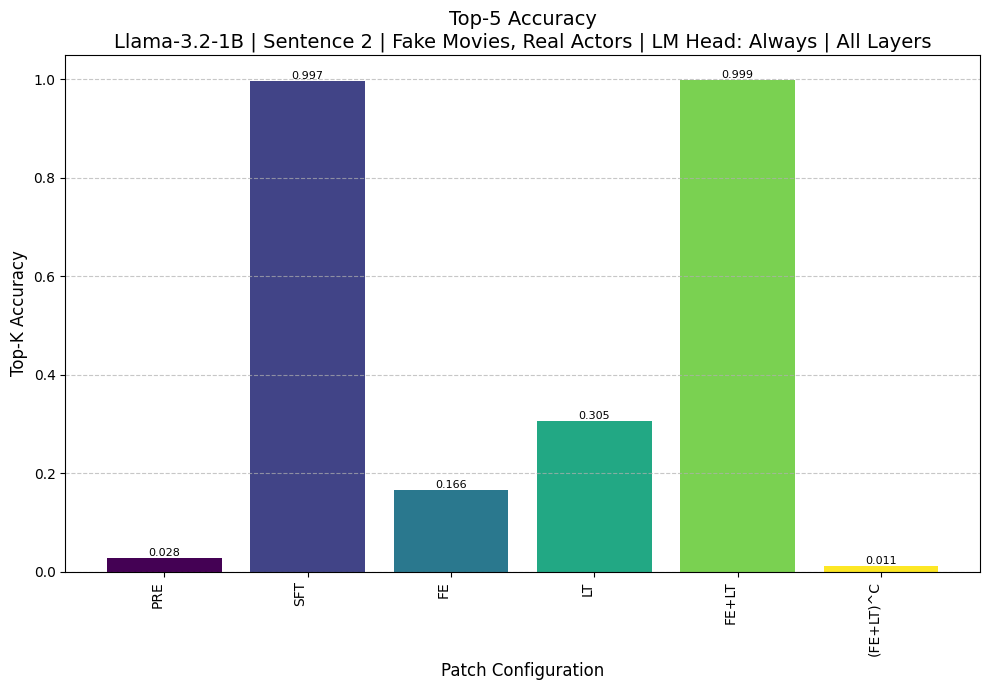

No valid data for top_k_accuracy in fake_movies_real_actors / sentence_3 / gemma
No valid data for top_k_accuracy in fake_movies_real_actors / sentence_3 / llama3


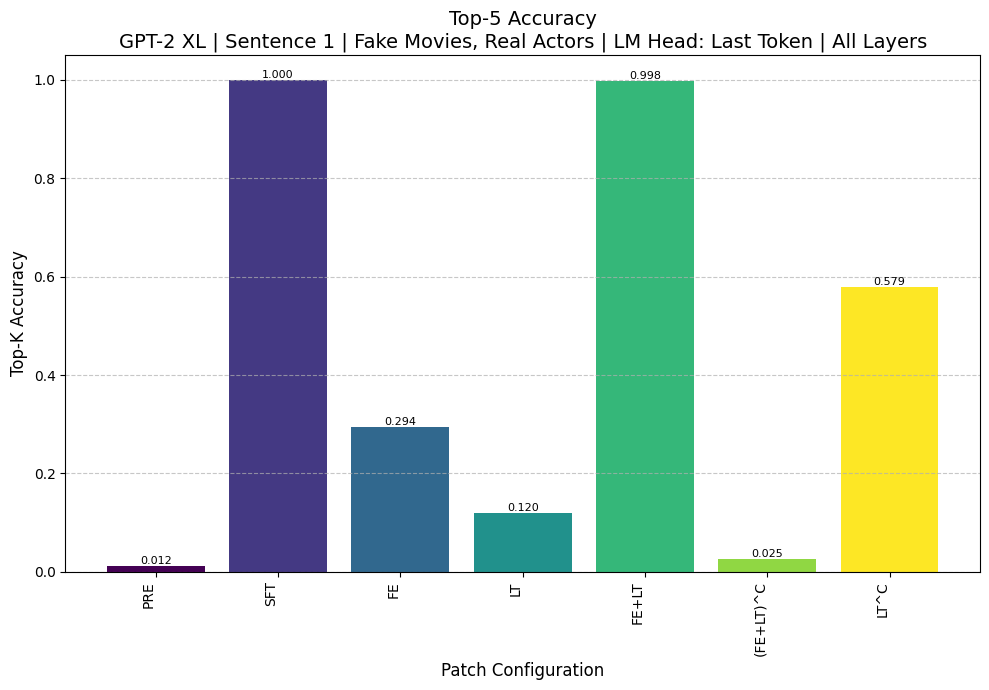

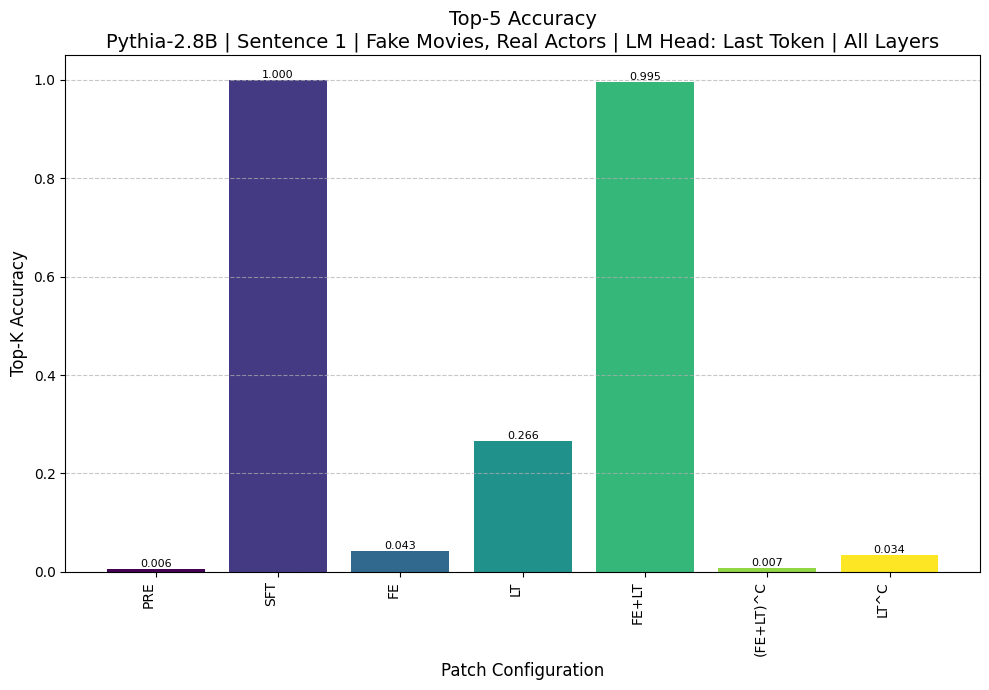

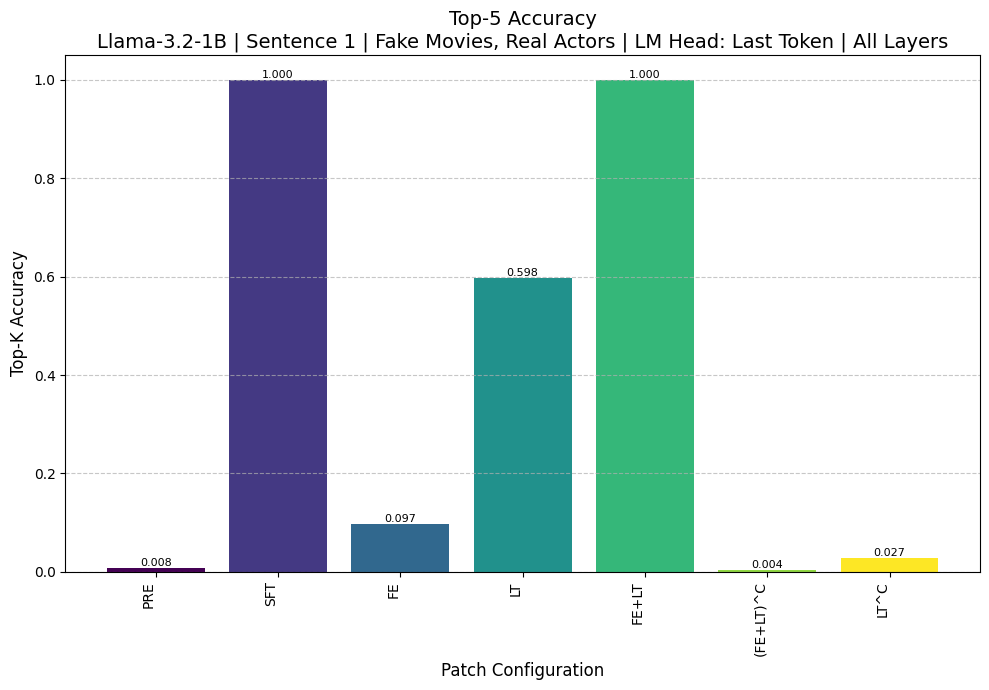

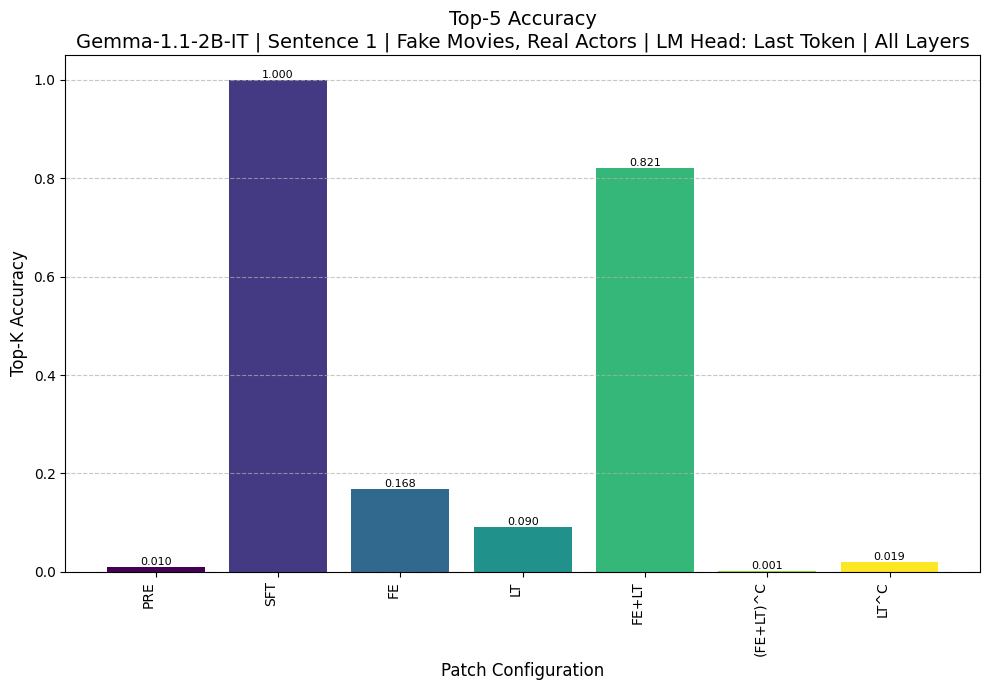

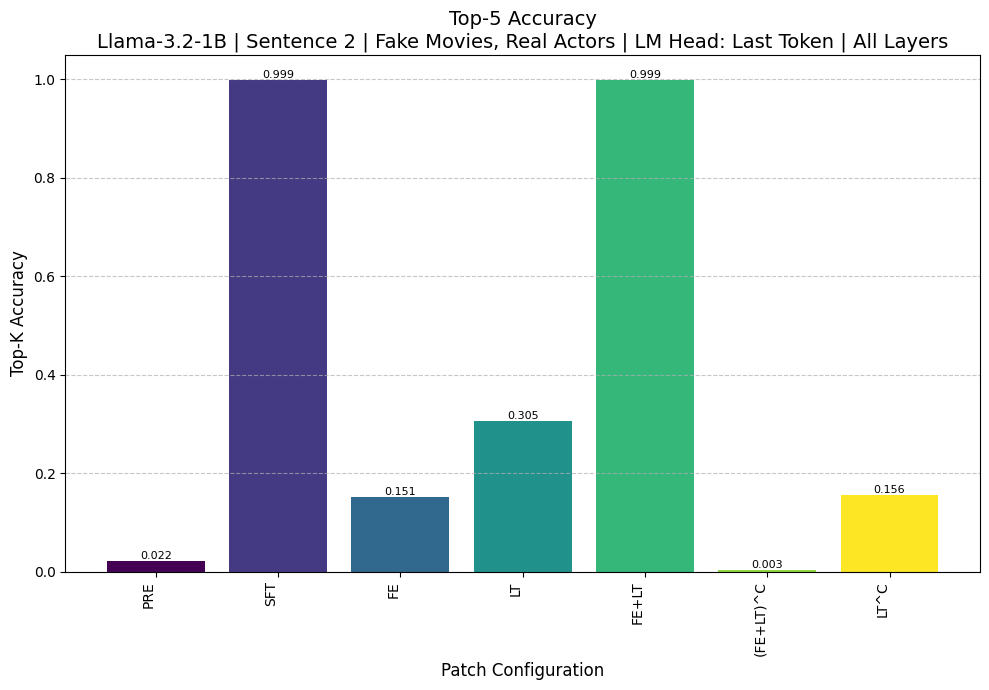

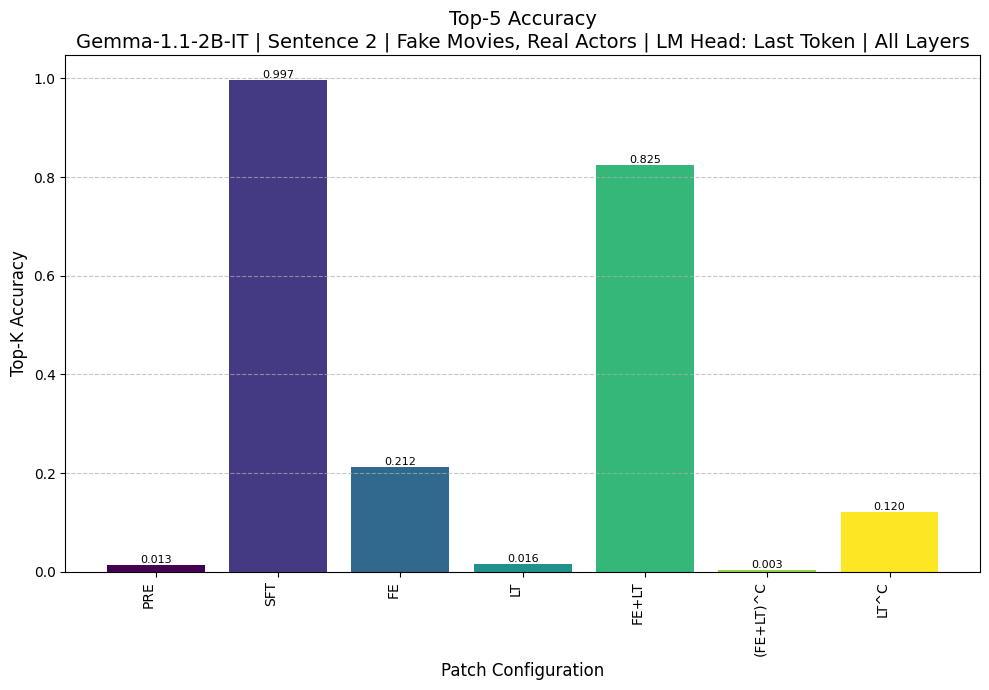

No valid data for top_k_accuracy in fake_movies_real_actors / sentence_3 / llama3
No valid data for top_k_accuracy in fake_movies_real_actors / sentence_3 / gemma


In [26]:
metric_key = "top_k_accuracy"
core_patches_only = True
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=False, core_patches_only=core_patches_only)

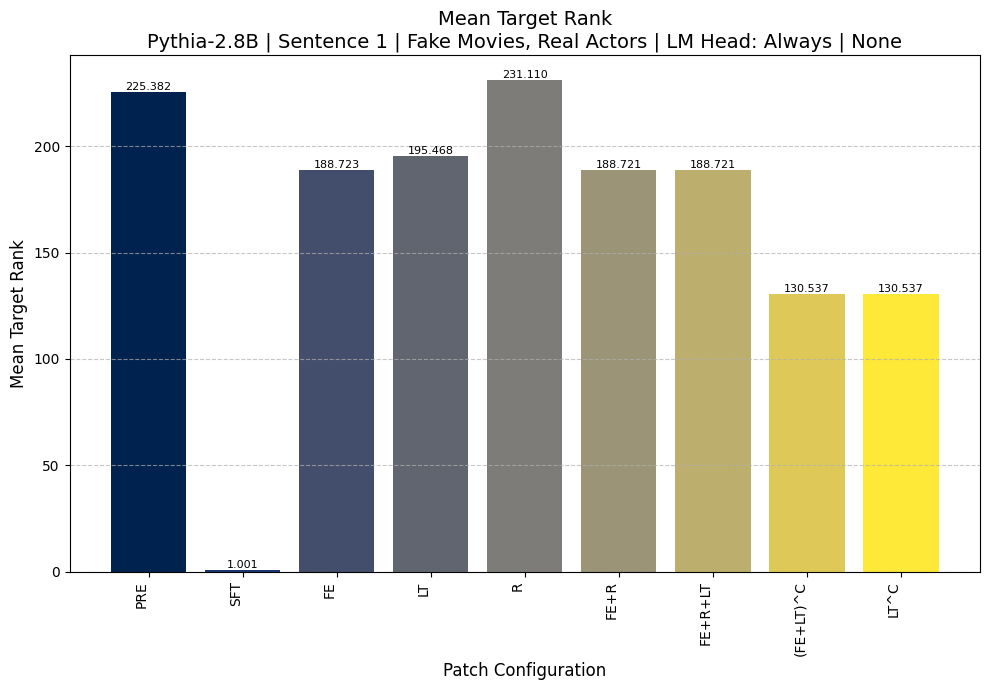

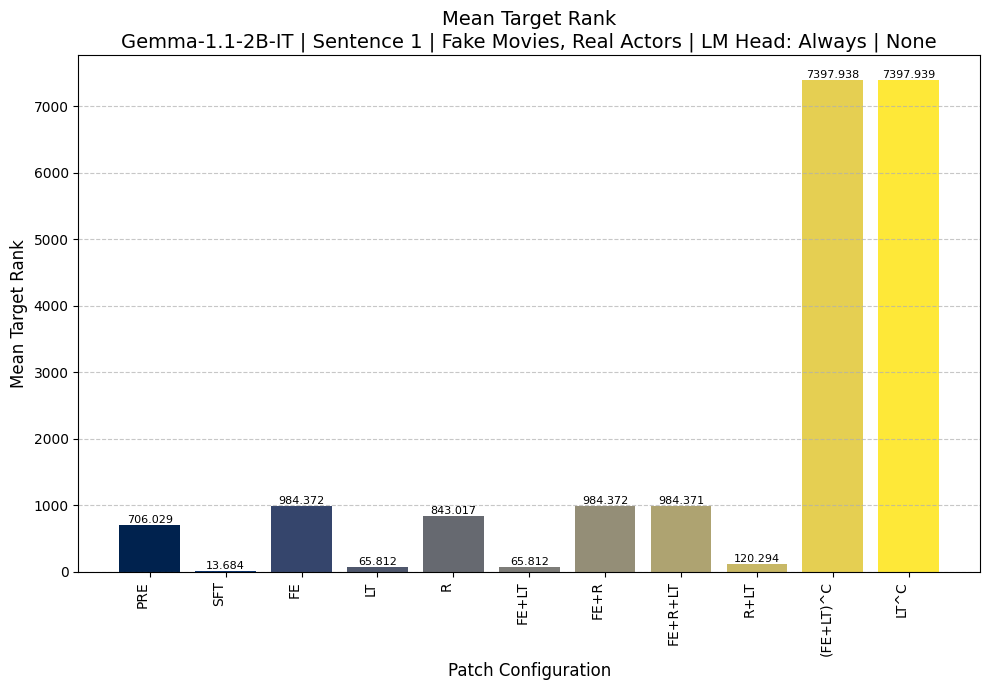

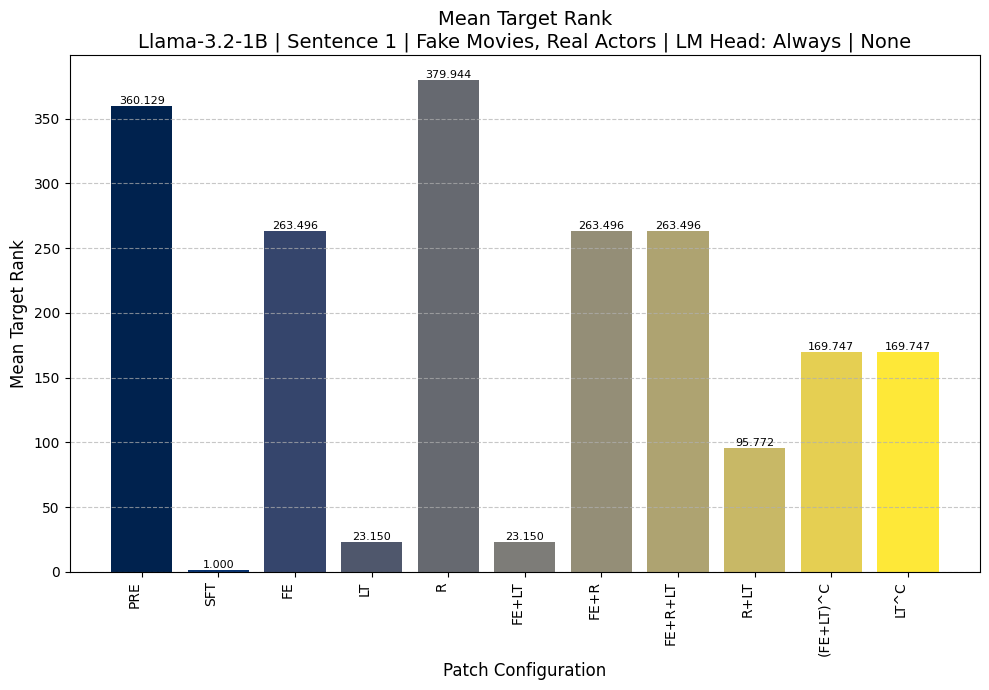

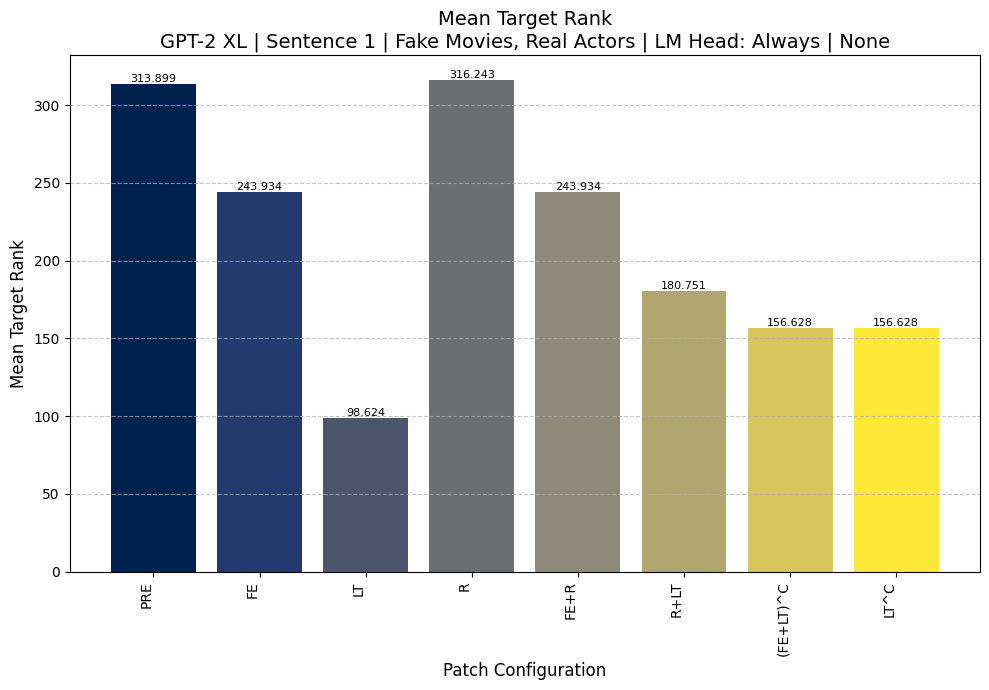

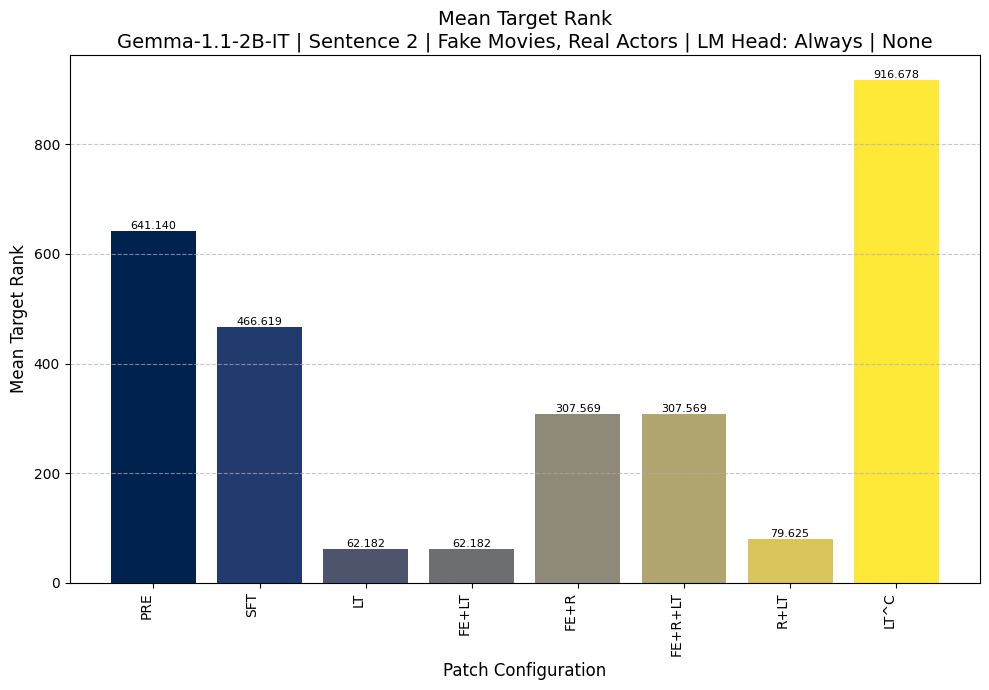

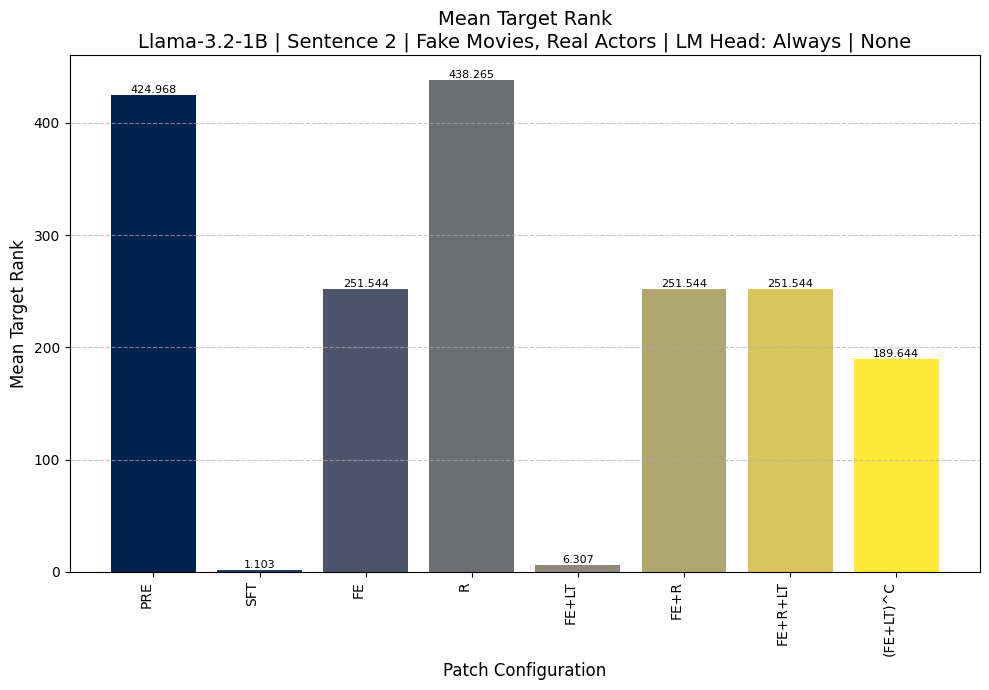

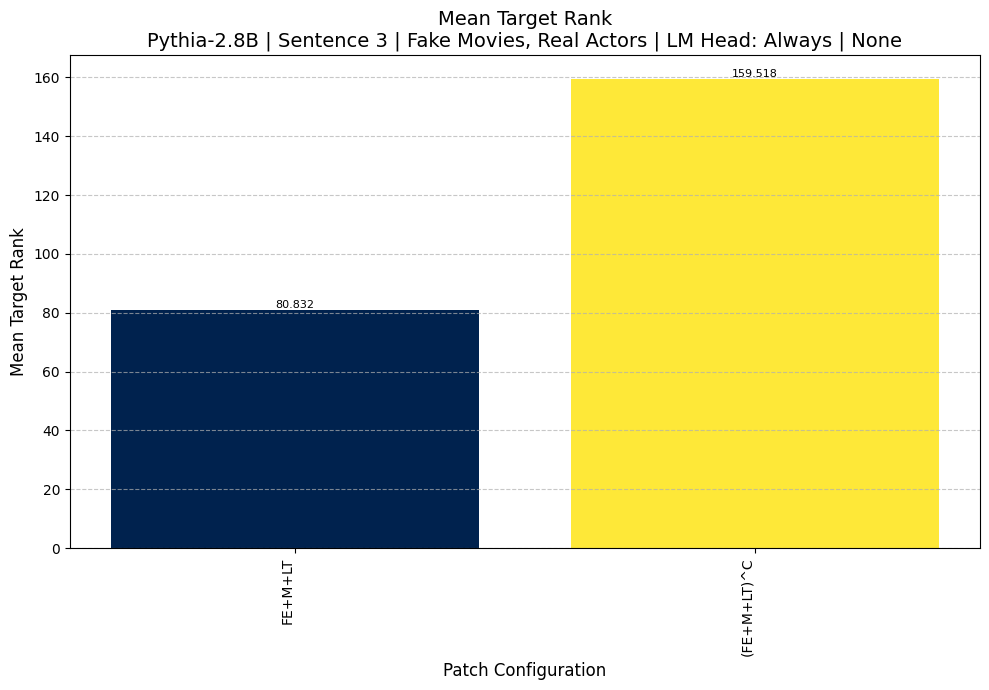

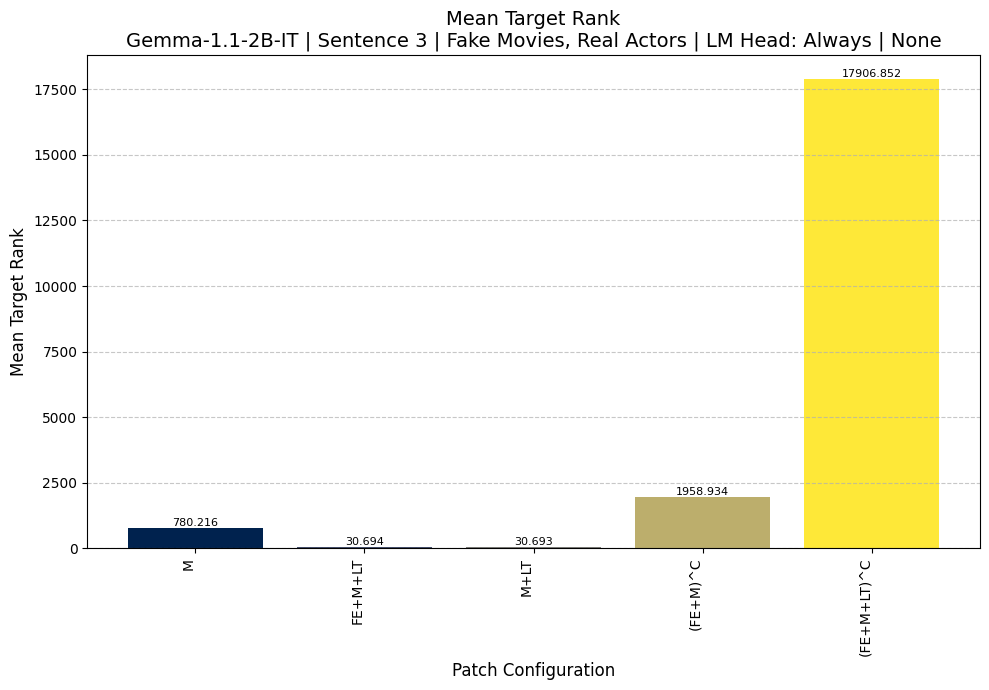

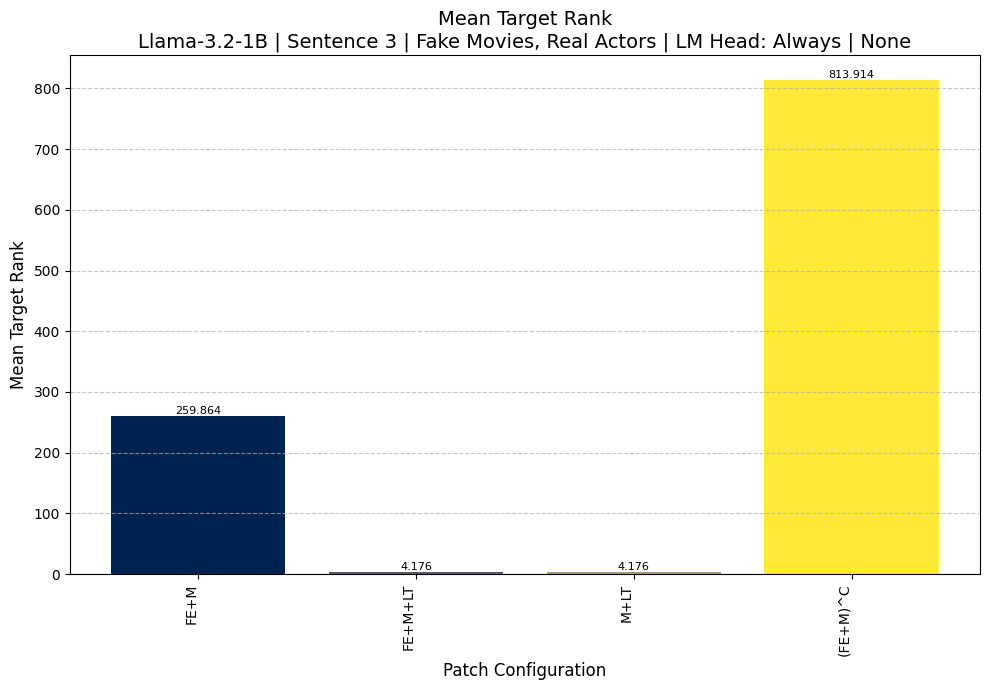

In [9]:
metric_key = "mean_target_rank"
plot_metric(organized_results, metric_key)

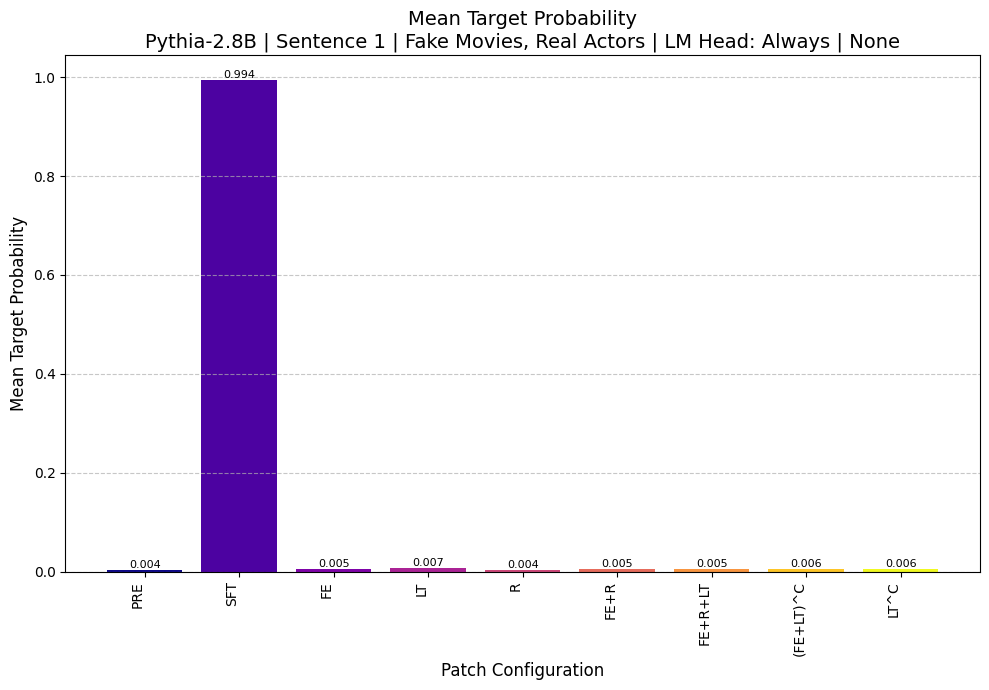

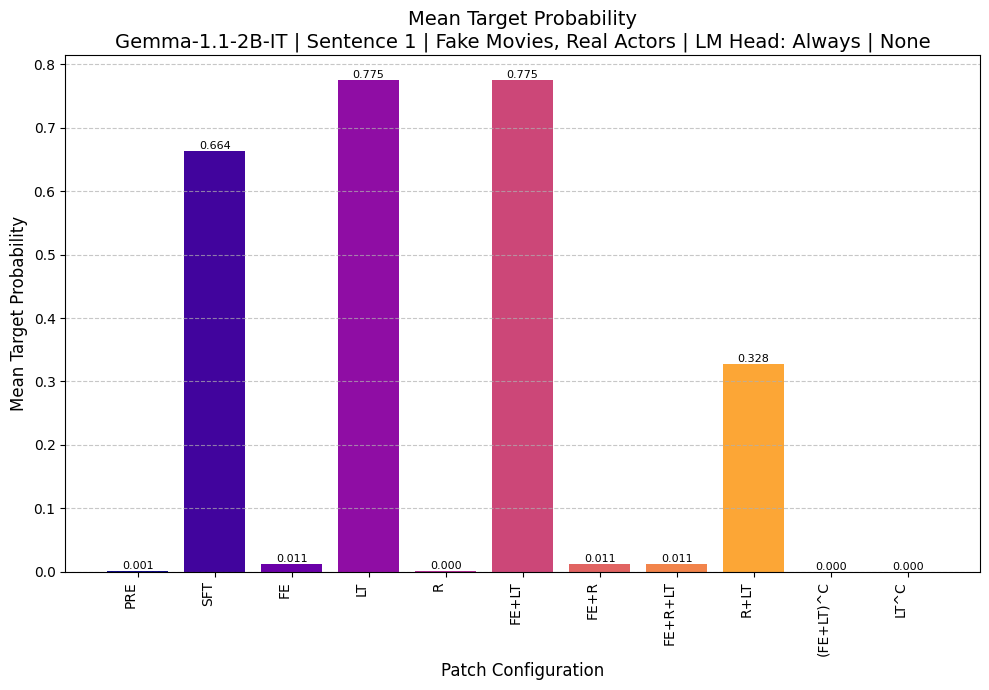

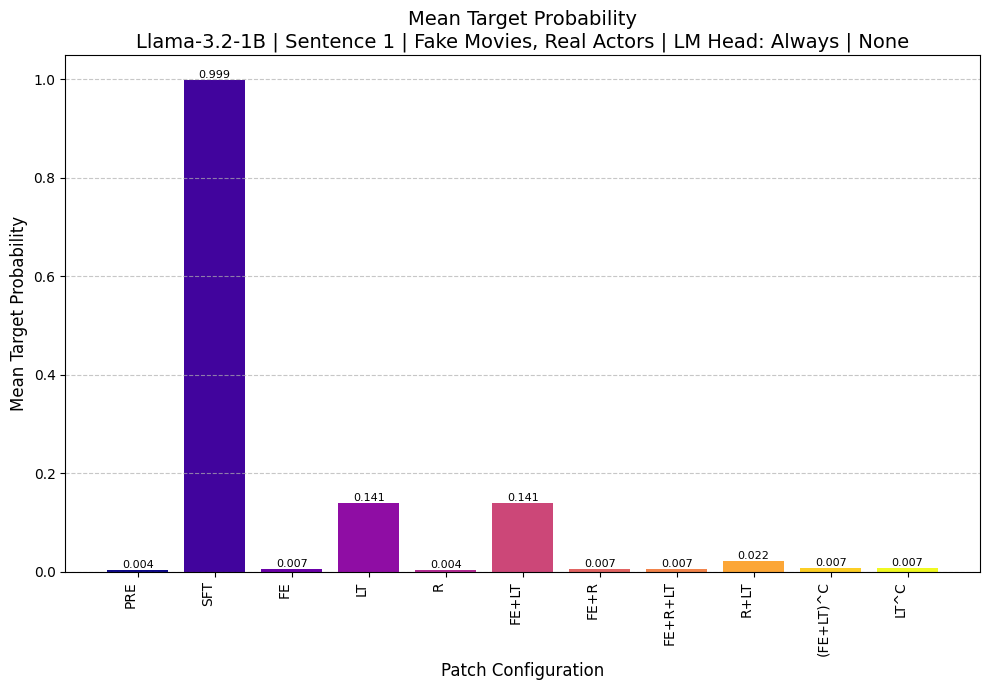

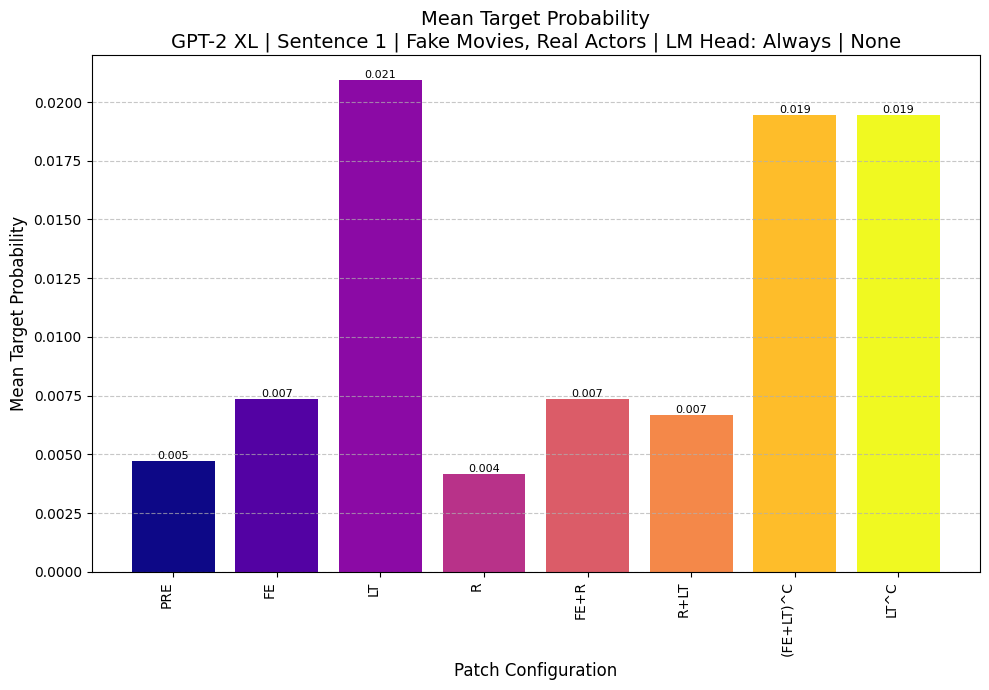

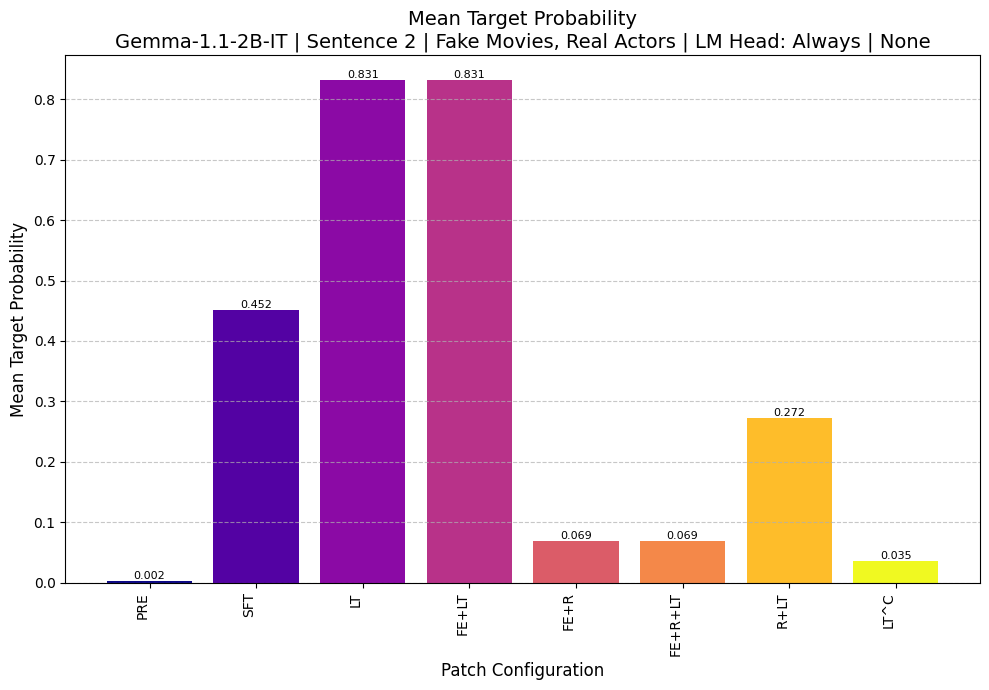

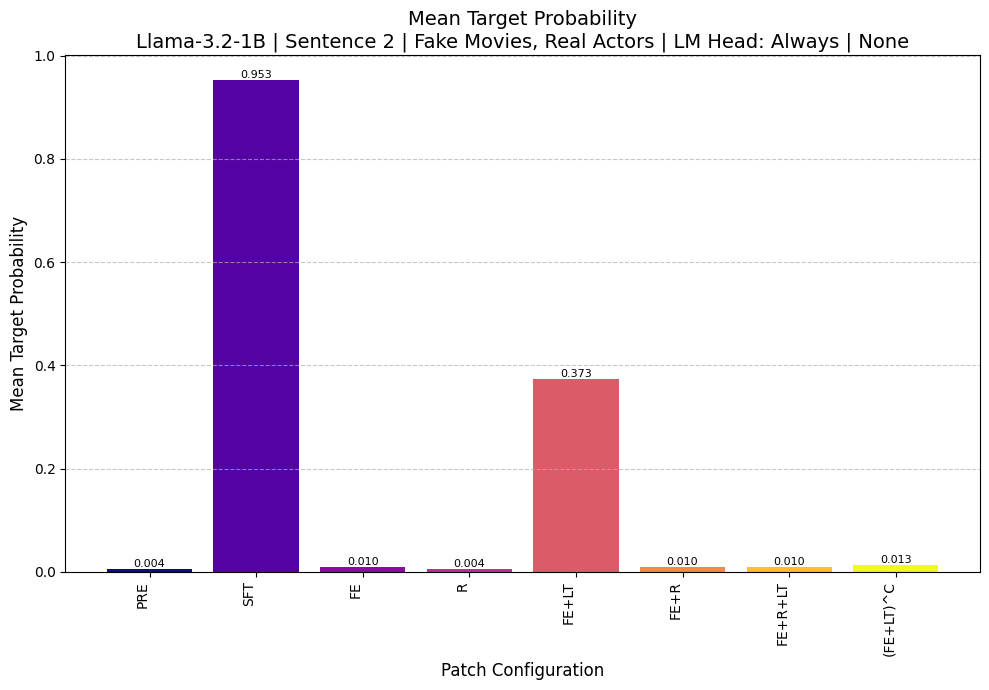

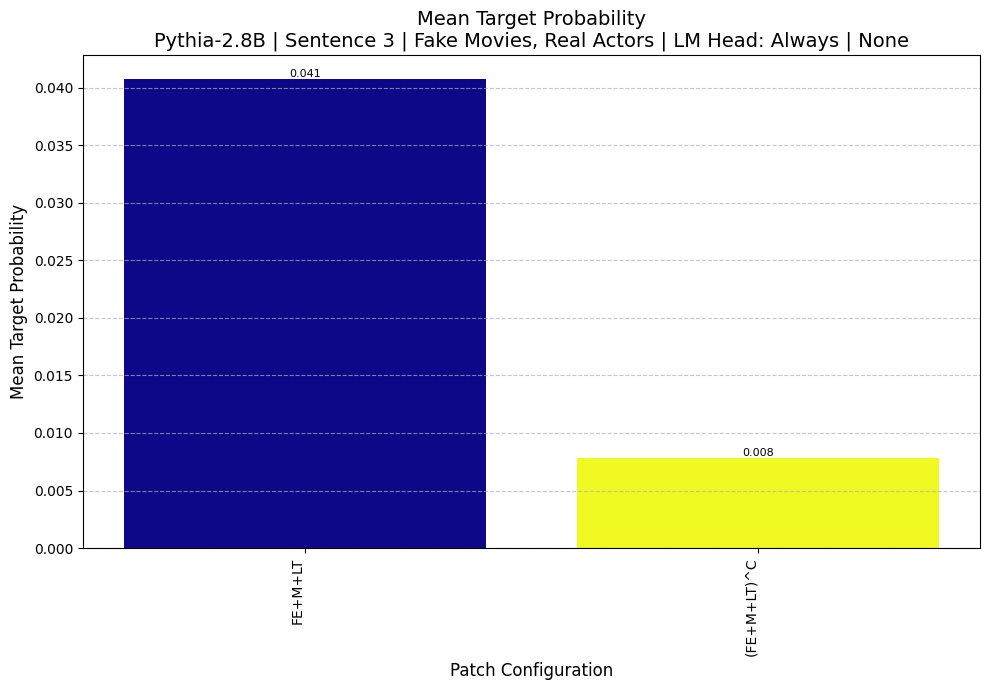

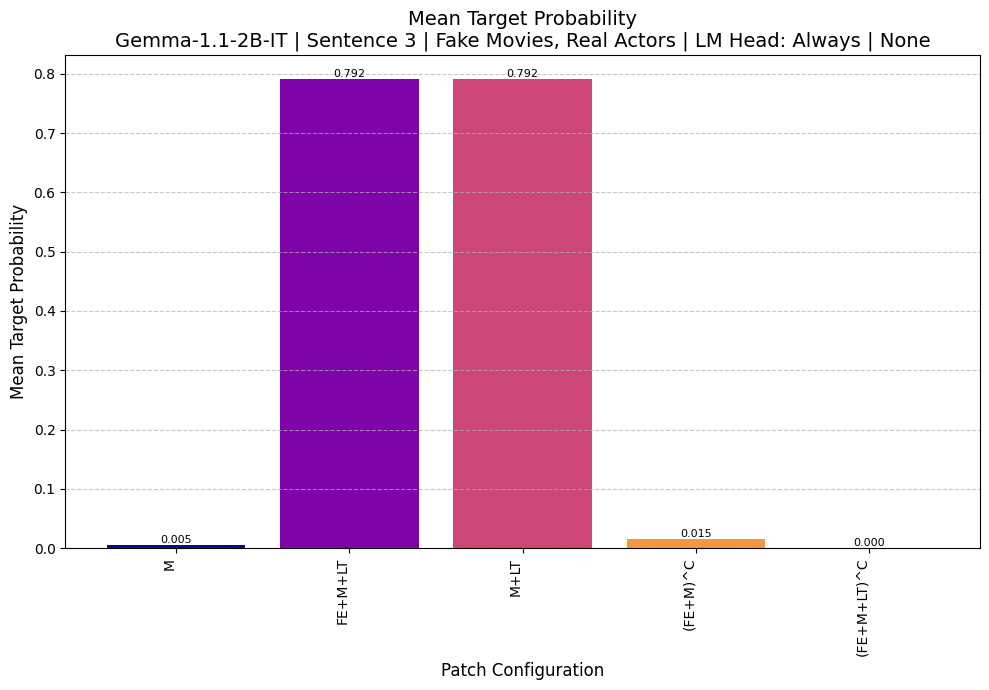

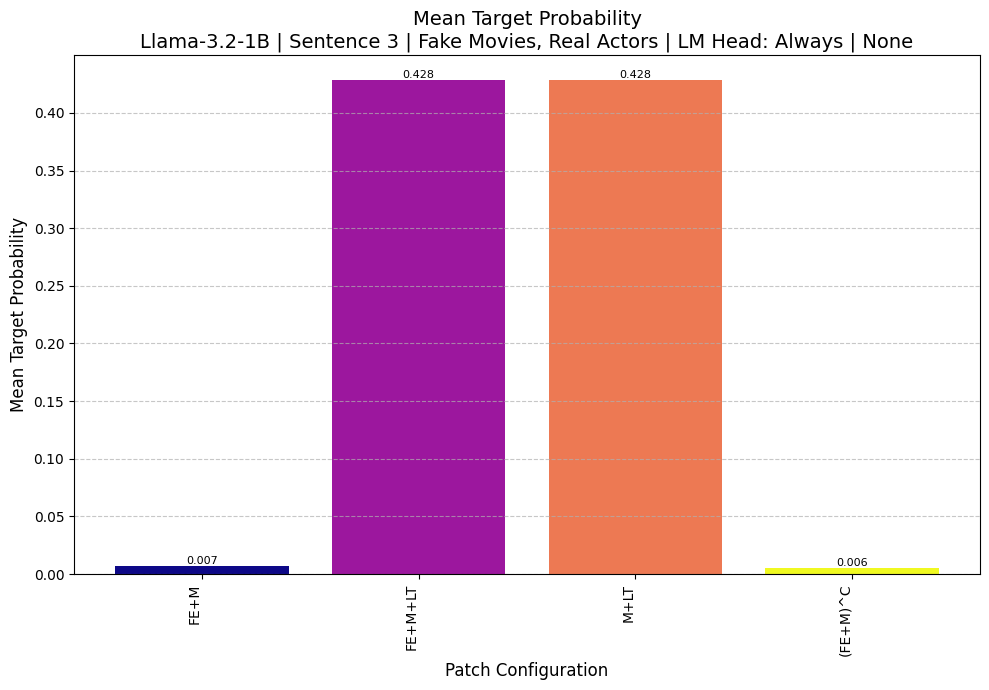

In [10]:
metric_key = "mean_target_prob"
plot_metric(organized_results, metric_key)